# Purpose
The purpose of this notebook is to generate supplemental figure 2, which focuses on Social Network analyses across ten years of rfid data from the mouse barn.

# Preliminaries

## load packages

In [1]:
%matplotlib inline
%autosave 60
%load_ext autoreload
%autoreload 2

#filesystem
import re
import os
import glob
from pathlib import Path
from tqdm import tqdm

#plotting
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
from dateutil import rrule
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, Normalize

#data
import numpy as np
import pandas as pd
import random
import ast
import pickle
import networkx as nx
import community
from datetime import datetime, timedelta
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.ndimage import gaussian_filter
from scipy.io import wavfile

# custom modules
from src import parameters,rfid, plot, preprocess, timestamps

Autosaving every 60 seconds


## paths

In [2]:
# project root - to reproduce, just change root to the full path to wild-mus-vocal-ecology
root = '/path/to/wild-mus-vocal-ecology'

# paths to rfid reading directories (each contains a directory for meets, stays, and box events)
all_rfid = os.path.join(root, 'data', 'rfid') # path to rfid data from 2013-2023 ("all")

# path to adult phenotypes (with sex)
adult_phenotypes_metadata_path = os.path.join(root, 'data', 'phenotypes', 'sexes.csv')

# path to save the temporary tabls
temporary_tables = ''

# path to save the figures
path_to_save = ''

# decide to do slow analyses or not
make_community_structure_graphs = True
make_small_world_graphs = True

# Get the data

## get phenotypes and sexes

In [3]:
phenos = pd.read_csv(adult_phenotypes_metadata_path, low_memory=False)
sex_dict = phenos.set_index('transponder_ID')['Sex'].to_dict()

In [4]:
sex_colors = {}
sex_colors['M'] = 'tomato'
sex_colors['F'] = 'skyblue'
sex_colors[float('NaN')] = 'grey'

## define the start and end of the dataset

In [5]:
dataset_start = pd.to_datetime('2013-01-01 00:00:00')
dataset_end = pd.to_datetime('2023-08-31 23:59:59') 

# Get seasonal  social networks (Panel A)
- This is identical to cell 4.4.1 in Figure 3.ipynb

In [1]:

#define seasons and years
seasons = ['summer', 'autumn', 'winter', 'spring']
season2023 = 'summer' # this is the only season to calculate when year == 2023
years = np.arange(2013,2024,1)

#initialize dictionaries
networks_dict = {} 
partitions_dict = {}
mouse_to_partition = {}
boxes_per_partition = {}
mice_per_partition = {}
partition_count = {}
modularity_dict = {}
avg_edge_weight_per_community = {}
avg_degree_per_community = {}
external_connections_per_community = {}
intercommunity_edges_count = {}
betweenness_centrality_dict = {}
unique_community_connections = {}
centrality_dict = {}

for year in years:
    mouse_to_partition[year] = {}
    print(year)
    next_year = year + 1 # to deal with winter
    
    networks_dict[year] = {} 
    partitions_dict[year] = {}
    boxes_per_partition[year] = {}
    mice_per_partition[year] = {}
    partition_count[year] = {}
    modularity_dict[year] = {}
    avg_edge_weight_per_community[year] = {}
    avg_degree_per_community[year] = {}
    external_connections_per_community[year] = {}
    intercommunity_edges_count[year] = {}
    betweenness_centrality_dict[year] = {}
    unique_community_connections[year] = {}
    centrality_dict[year] = {}
    
    for season in seasons:
        mouse_to_partition[year][season] = {}
        boxes_per_partition[year][season] = {}
        mice_per_partition[year][season] = {}
        partition_count[year][season] = {}
        modularity_dict[year][season] = {}
        avg_edge_weight_per_community[year][season] = {}
        avg_degree_per_community[year][season] = {}
        external_connections_per_community[year][season] = {}
        intercommunity_edges_count[year][season] = {}
        betweenness_centrality_dict[year][season] = {}
        unique_community_connections[year][season] = {}
        centrality_dict[year][season] = {}
        
        if (season == 'winter'): # note we have 2024 jan/feb data but will not analyse it here

            print('\t',season)
            
            #load the saved meets from this year and season (note "winter" of year n is Decemeber of year n plus Jan/Feb of year n+1)
            months = ['01', '02']
            meet_paths = glob.glob(os.path.join(all_rfid,  'mouse_meets',str(year)+'12'+'01*.feather'))
            stay_paths = glob.glob(os.path.join(all_rfid,  'mouse_stays',str(year)+'12'+'01*.feather'))
            for month in months:
                meet_paths.extend(glob.glob(os.path.join(all_rfid,  'mouse_meets',str(year+1)+month+'01*.feather')))
                stay_paths.extend(glob.glob(os.path.join(all_rfid,  'mouse_stays',str(year+1)+month+'01*.feather')))

            # get the mice who will contribute to the social network (the ones who met at least one other mouse)
            these_meets = pd.concat([pd.read_feather(i) for i in meet_paths])
            these_stays = pd.concat([pd.read_feather(i) for i in stay_paths])
            
            #ignore closed (odd) boxes if 2021 or later
            if year >=2021:
                these_meets = these_meets[~(these_meets['box'] % 2 != 0)]
                these_stays = these_stays[~(these_stays['box_number'] % 2 != 0)]
            
            # get the mice
            meets_mice = list(these_meets['id1'].unique()) + list(these_meets['id2'].unique()) #get the id's associated with each meeting mouse's stay
            stays_mice = list(these_stays['transponder_id'].unique())
            these_mice = list(set(meets_mice).intersection(stays_mice))

            #only keep mice where we have stay information
            these_meets = these_meets[(these_meets['id1'].isin(these_mice)) & (these_meets['id2'].isin(these_mice))]
            these_stays = these_stays[these_stays['transponder_id'].isin(these_mice)] #find these stays

        elif season == 'spring':
            print('\t',season)
            #load the saved meets from this year and season (note winter of year n is Decemeber of year n plus Jan/Feb of year n+1)
            months = ['03', '04', '05']
            meet_paths = []
            stay_paths = []
            for month in months:
                meet_paths.extend(glob.glob(os.path.join(all_rfid,  'mouse_meets',str(year)+month+'01*.feather')))
                stay_paths.extend(glob.glob(os.path.join(all_rfid,  'mouse_stays',str(year)+month+'01*.feather')))

            # get the mice who will contribute to the social network (the ones who met at least one other mouse)
            these_meets = pd.concat([pd.read_feather(i) for i in meet_paths])
            these_stays = pd.concat([pd.read_feather(i) for i in stay_paths])
            
            #ignore closed (odd) boxes if 2021 or later
            if year >=2021:
                these_meets = these_meets[~(these_meets['box'] % 2 != 0)]
                these_stays = these_stays[~(these_stays['box_number'] % 2 != 0)]
                
            # get the mice
            meets_mice = list(these_meets['id1'].unique()) + list(these_meets['id2'].unique()) #get the id's associated with each meeting mouse's stay
            stays_mice = list(these_stays['transponder_id'].unique())
            these_mice = list(set(meets_mice).intersection(stays_mice))

            #only keep mice where we have stay information
            these_meets = these_meets[(these_meets['id1'].isin(these_mice)) & (these_meets['id2'].isin(these_mice))]
            these_stays = these_stays[these_stays['transponder_id'].isin(these_mice)] #find these stays

        elif season == 'autumn':
            print('\t',season)
            #load the saved meets from this year and season (note winter of year n is Decemeber of year n plus Jan/Feb of year n+1)
            months = ['09', '10', '11']
            meet_paths = []
            stay_paths = []
            for month in months:
                meet_paths.extend(glob.glob(os.path.join(all_rfid,  'mouse_meets',str(year)+month+'01*.feather')))
                stay_paths.extend(glob.glob(os.path.join(all_rfid,  'mouse_stays',str(year)+month+'01*.feather')))

            # get the mice who will contribute to the social network (the ones who met at least one other mouse)
            these_meets = pd.concat([pd.read_feather(i) for i in meet_paths])
            these_stays = pd.concat([pd.read_feather(i) for i in stay_paths])
            
            #ignore closed (odd) boxes if 2021 or later
            if year >=2021:
                these_meets = these_meets[~(these_meets['box'] % 2 != 0)]
                these_stays = these_stays[~(these_stays['box_number'] % 2 != 0)]
            
            # get the mice
            meets_mice = list(these_meets['id1'].unique()) + list(these_meets['id2'].unique()) #get the id's associated with each meeting mouse's stay
            stays_mice = list(these_stays['transponder_id'].unique())
            these_mice = list(set(meets_mice).intersection(stays_mice))

            #only keep mice where we have stay information
            these_meets = these_meets[(these_meets['id1'].isin(these_mice)) & (these_meets['id2'].isin(these_mice))]
            these_stays = these_stays[these_stays['transponder_id'].isin(these_mice)] #find these stays

        elif season == 'summer':
            print('\t',season)
            #load the saved meets from this year and season (note winter of year n is Decemeber of year n plus Jan/Feb of year n+1)
            months = ['06', '07', '08']
            meet_paths = []
            stay_paths = []
            for month in months:
                meet_paths.extend(glob.glob(os.path.join(all_rfid,  'mouse_meets',str(year)+month+'01*.feather')))
                stay_paths.extend(glob.glob(os.path.join(all_rfid,  'mouse_stays',str(year)+month+'01*.feather')))

            # get the mice who will contribute to the social network (the ones who met at least one other mouse)
            these_meets = pd.concat([pd.read_feather(i) for i in meet_paths])
            these_stays = pd.concat([pd.read_feather(i) for i in stay_paths])
            
            #ignore closed (odd) boxes if 2021 or later
            if year >=2021:
                these_meets = these_meets[~(these_meets['box'] % 2 != 0)]
                these_stays = these_stays[~(these_stays['box_number'] % 2 != 0)]
            
            #get the mice
            meets_mice = list(these_meets['id1'].unique()) + list(these_meets['id2'].unique()) #get the id's associated with each meeting mouse's stay
            stays_mice = list(these_stays['transponder_id'].unique())
            these_mice = list(set(meets_mice).intersection(stays_mice))

            #only keep mice where we have stay information
            these_meets = these_meets[(these_meets['id1'].isin(these_mice)) & (these_meets['id2'].isin(these_mice))]
            these_stays = these_stays[these_stays['transponder_id'].isin(these_mice)] #find these stays

        #make sure there is data
        if (len(these_meets) > 0) & (len(these_stays) > 0):

            # make the graph
            graph = rfid.get_igraph_network(meets_df=these_meets, stays_df=these_stays, weight=True)
            G = graph.to_networkx() # convert to networkx for ease of use in python

            for idx in graph.vs.indices: #for each node
                for attr in graph.vs.attributes(): #port the attributes from igraph
                    G.nodes[idx][attr] = graph.vs[idx][attr]

            #rename the nodes
            rename_dict = {}
            for key in G.nodes():
                rename_dict[key] = G.nodes[key]['name']
                G = nx.relabel_nodes(G, rename_dict)

            #find clusters using Louvain algorithm
            partition = community.best_partition(G, random_state = 123456)
            
            # calculate modularity
            modularity = community.modularity(partition, G)

            #assign cluster identity as an attribute to each node
            for node_id, community_id in partition.items():
                G.nodes[node_id]['community_id'] = community_id          

            #add sex
            for idx, attributes in G.nodes(data=True): # add phenotypes from the phenotype table
                G.nodes[idx]['sex'] = sex_dict.get(attributes['name'], float('NaN'))
                
             # Calculate node betweenness centrality (using networkx)
            betweenness_centrality = nx.betweenness_centrality(G)

            #assign betweenness centrality to each node in the G graph
            for node_id, centrality in betweenness_centrality.items():
                G.nodes[node_id]['betweenness_centrality'] = centrality

            #calculate the number of unique communities each node connects to
            community_connections = {}
            for node_id in G.nodes:
                neighbors = list(G.neighbors(node_id))
                unique_communities = set(partition[n] for n in neighbors if n != node_id)
                community_connections[node_id] = len(unique_communities)

            #get node graph properties and make it an attribute
            degree_centrality = nx.centrality.degree_centrality(G)
            degree = {node: G.degree[node] for node in G.nodes}
            clustering_coefficients = {node: nx.clustering(G, node) for node in G.nodes}
            for idx, attributes in G.nodes(data=True):
                G.nodes[idx]['degree'] = degree[idx]
                G.nodes[idx]['centrality'] = degree_centrality[idx]
                G.nodes[idx]['clustering_coeff'] = clustering_coefficients[idx]
                
            #calculate average edge weight per community
            community_edge_weights = {c: [] for c in set(partition.values())}
            for (u, v, data) in G.edges(data=True):
                community_u = partition[u]
                community_v = partition[v]
                if community_u == community_v:
                    community_edge_weights[community_u].append(data['weight'])
            avg_edge_weight = {c: np.mean(weights) if weights else 0 for c, weights in community_edge_weights.items()}
            
            #calculate average degree per community
            community_degrees = {c: [] for c in set(partition.values())}
            for node in G.nodes:
                this_community = partition[node]
                community_degrees[this_community].append(G.degree[node])
            avg_degree = {c: np.mean(degrees) if degrees else 0 for c, degrees in community_degrees.items()}

            #get the number of boxes visited for each node using the stays table
            for node in G.nodes:
                G.nodes[node]['boxes_visited'] = these_stays[these_stays['transponder_id'] == node]['box_number'].nunique()
                
            #get number of clusters from best partition
            num_clusters = len(set(partition.values()))
            
            #get the number of unique boxes per cluster from the best partition
            unique_boxes_per_cluster = {c: these_stays[these_stays['transponder_id'].isin([n for n in partition if partition[n] == c])]['box_number'].to_list() for c in set(partition.values())}
            
            #get the number of mice per cluster from the best partition
            mice_per_cluster = {c: list(partition.values()).count(c) for c in set(partition.values())}
            
            #make a dictionary that maps mouse ID to partition from best partition
            for mouse in partition:
                mouse_to_partition[year][season][mouse] = partition[mouse]
                
            # Calculate the number of members of each community that have an edge with a node outside of the community
            external_connections = {c: 0 for c in set(partition.values())}
            community_edges = {c: set() for c in set(partition.values())}  # Use sets to track unique intercommunity connections
            for node in G.nodes:
                node_community = partition[node]
                for neighbor in G.neighbors(node):
                    neighbor_community = partition[neighbor]
                    if neighbor_community != node_community:
                        external_connections[node_community] += 1
                        community_edges[node_community].add(neighbor_community)  # Add unique connections to the set
            
            # Count the number of unique other communities each community is connected to
            intercommunity_count = {c: len(communities) for c, communities in community_edges.items()}

            #assign to dictionary
            networks_dict[year][season] = G
            partitions_dict[year][season] = partition
            boxes_per_partition[year][season] = unique_boxes_per_cluster
            mice_per_partition[year][season] = mice_per_cluster
            partition_count[year][season] = num_clusters
            modularity_dict[year][season] = modularity
            avg_edge_weight_per_community[year][season] = avg_edge_weight
            avg_degree_per_community[year][season] = avg_degree
            external_connections_per_community[year][season] = external_connections
            intercommunity_edges_count[year][season] = intercommunity_count
            betweenness_centrality_dict[year][season] = betweenness_centrality
            unique_community_connections[year][season] = community_connections
            centrality_dict[year][season] = degree_centrality

        else:
            print(season, 'in', year, 'has no meets or stays...')
            networks_dict[year][season] = None
            partitions_dict[year][season] = None
            boxes_per_partition[year][season] = None
            mice_per_partition[year][season] = None
            partition_count[year][season] = None
            modularity_dict[year][season] = None
            avg_edge_weight_per_community[year][season] = None
            avg_degree_per_community[year][season] = None
            external_connections_per_community[year][season] = None
            intercommunity_edges_count[year][season] = None
            betweenness_centrality_dict[year][season] = None
            unique_community_connections[year][season] = None
            centrality_dict[year][season] = None

print('done.')

# Get actual and control modularities for seasonal networks

In [2]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
import numpy as np
from scipy.stats import norm
import concurrent.futures

years = range(2013, 2024)
seasons = ['autumn', 'winter', 'spring', 'summer']
num_null_models = 100  # Number of null hypothesis networks to generate

modularity_results = {}

def calculate_null_modularity(G):
    
    #generate a random network network with the same size and degree distribution as G
    G_null = nx.configuration_model([d for n, d in G.degree()])
    G_null = nx.Graph(G_null)  # Convert to simple graph
    G_null.remove_edges_from(nx.selfloop_edges(G_null))  # Remove self-loops

    #calculate its modularity
    null_partition = community.best_partition(G_null)
    null_modularity = community.modularity(null_partition, G_null)
    return null_modularity

for year in years:
    print(year)
    modularity_results[year] = {}
    
    for season in seasons:
        
        print('\t', season)
        
        if year in networks_dict and season in networks_dict[year]:
           
            # Get the modularity you just calculated
            modularity_original = modularity_dict[year][season]
            
            if not modularity_original is None:
                
                 # Extract the original network
                G = networks_dict[year][season]

                # Generate null model networks and calculate their modularity
                null_modularities = []

                for _ in tqdm(range(num_null_models)):
                    null_modularity = calculate_null_modularity(G)
                    null_modularities.append(null_modularity)

                # Calculate the mean and standard deviation of the null model modularities
                mu_null = np.mean(null_modularities)
                sigma_null = np.std(null_modularities)

                # Calculate the Z-score
                z_score = (modularity_original - mu_null) / sigma_null

                # Calculate the p-valye
                p_value = norm.sf(abs(z_score)) * 2  # two-tailed test

                modularity_results[year][season] = {
                    'modularity_original': modularity_original,
                    'mu_null': mu_null,
                    'sigma_null': sigma_null,
                    'z_score': z_score,
                    'p-value':p_value,
                    'null_modularities': null_modularities
                }

In [8]:
# Initialize an empty list to store flattened results
flat_results = []

# Flatten the nested dictionary into a list of dictionaries
for year in modularity_results:
    for season in modularity_results[year]:
        data = modularity_results[year][season]
        flat_results.append({
            'year': year,
            'season': season,
            'modularity_original': data['modularity_original'],
            'mu_null': data['mu_null'],
            'sigma_null': data['sigma_null'],
            'Z_score': data['z_score'],
            'p_value': data['p-value'],
            'null_modularities': data['null_modularities']
        })

# Create a DataFrame from the flattened results
modularities_df = pd.DataFrame(flat_results)
modularities_df.to_csv('path/to/modularities_df.csv', index = False)

# Get small world coefficients for seasonal networks

In [3]:
import networkx as nx
import numpy as np
from tqdm import tqdm
import concurrent.futures

years = range(2013, 2024)
seasons = ['autumn', 'winter', 'spring', 'summer']
num_null_models = 100  # Number of null hypothesis networks to generate
small_world_results = {}
random_seed = 123456

def calculate_null_small_world_metrics(G):
    # Generate a configuration model network
    G_null = nx.configuration_model([d for n, d in G.degree()], seed=random_seed)
    G_null = nx.Graph(G_null)  # Convert to simple graph
    G_null.remove_edges_from(nx.selfloop_edges(G_null))  # Remove self-loops

    # Calculate the clustering coefficient and average shortest path length of the null model network
    clustering_coeff_null = nx.average_clustering(G_null)
    try:
        avg_shortest_path_length_null = nx.average_shortest_path_length(G_null)
    except nx.NetworkXError:  # Handle disconnected graphs
        avg_shortest_path_length_null = float('inf')
    
    return clustering_coeff_null, avg_shortest_path_length_null

for year in years:
    print(year)
    small_world_results[year] = {}
    
    for season in seasons:
        
        print('\t', season)
        
        if year in networks_dict and season in networks_dict[year]:

            # Extract the original network
            G = networks_dict[year][season]
            
            if G is not None:
                # Calculate the clustering coefficient and average shortest path length of the original graph
                clustering_coeff_actual = nx.average_clustering(G)
                try:
                    avg_shortest_path_length_actual = nx.average_shortest_path_length(G)
                    small_world_metric_defined = True
                except nx.NetworkXError:  # errors will be caused by disconnected graphs, which we will ignore (there is only one, in autumn of 2016)
                    small_world_metric_defined = False # this metric is not defined for disconnected graphs (bc of "infinite" distance bw some nodes)
                    
                # Generate null model networks and calculate their metrics
                null_clustering_coeffs = []
                null_avg_shortest_path_lengths = []

                for _ in tqdm(range(num_null_models)):
                    clustering_coeff_null, avg_shortest_path_length_null = calculate_null_small_world_metrics(G)
                    null_clustering_coeffs.append(clustering_coeff_null)
                    null_avg_shortest_path_lengths.append(avg_shortest_path_length_null)

                #the mean and standard deviation of the null model metrics
                mu_clustering_coeff_null = np.mean(null_clustering_coeffs)
                mu_avg_shortest_path_length_null = np.mean(null_avg_shortest_path_lengths)

                if small_world_metric_defined: 
                    #sigma is the "small world metric" or "small world coefficient"
                    sigma = (clustering_coeff_actual / mu_clustering_coeff_null) / (avg_shortest_path_length_actual / mu_avg_shortest_path_length_null)
                else:
                    sigma = float('NaN')
                small_world_results[year][season] = {
                    'clustering_coeff_actual': clustering_coeff_actual,
                    'avg_shortest_path_length_actual': avg_shortest_path_length_actual,
                    'mu_clustering_coeff_null': mu_clustering_coeff_null,
                    'mu_avg_shortest_path_length_null': mu_avg_shortest_path_length_null,
                    'sigma': sigma,
                    'null_clustering_coeffs': null_clustering_coeffs,
                    'null_avg_shortest_path_lengths': null_avg_shortest_path_lengths
                }
            else:
                small_world_results[year][season] = None





In [60]:
# Make a dataframe from the dictionary you just make
# Initialize a list to store flattened results
flat_results = []

#iterate over the dictionary to flatten it
for year in small_world_results:
    for season in small_world_results[year]:
        
        data = small_world_results[year][season]
        
        if not data is None:
            flat_results.append({
                'year': year,
                'season': season,
                'clustering_coeff_actual': data['clustering_coeff_actual'],
                'avg_shortest_path_length_actual': data['avg_shortest_path_length_actual'],
                'mu_clustering_coeff_null': data['mu_clustering_coeff_null'],
                'mu_avg_shortest_path_length_null': data['mu_avg_shortest_path_length_null'],
                'sigma': data['sigma'],
                'null_clustering_coeffs': data['null_clustering_coeffs'],
                'null_avg_shortest_path_lengths': data['null_avg_shortest_path_lengths']
            })

#make the df
small_world_df = pd.DataFrame(flat_results)
small_world_df.to_csv('/path/to/small_world_df.csv', index = False)

/var/folders/h6/6fyt3jld5pq_w03ql1jw0gnh0000gn/T/ipykernel_7556/4098810599.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = small_world_df,


<Axes: xlabel='season', ylabel='sigma'>

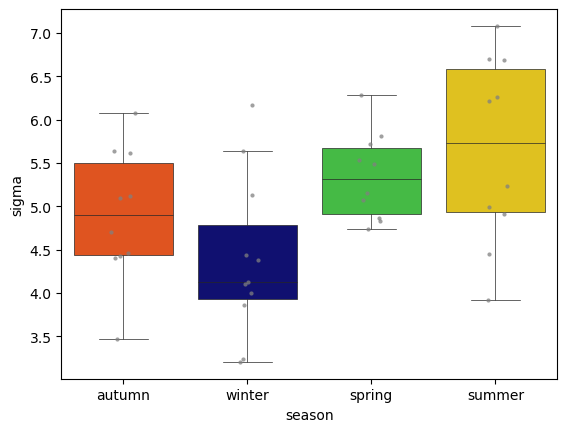

In [63]:
season_colors_path = os.path.join(root,'parameters', 'json_files','season_color_dict.json')
season_colors = parameters.load_json(season_colors_path)

sns.boxplot(data = small_world_df, 
            x = 'season', 
            y = 'sigma', 
            showfliers = False, 
            palette = [season_colors[season] for season in small_world_df['season'].unique()], 
            linewidth = 0.5)
sns.stripplot(data = small_world_df, 
              x = 'season', 
              y = 'sigma', 
              s = 3, 
              color = 'grey', 
              alpha = 0.75,
              dodge=True,  # Add dodge=True to avoid overlap
              legend=False)

In [4]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pandas as pd
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

#fit the model, dropping nan and inf
data=small_world_df[small_world_df['sigma'] < 1000000].dropna(subset = 'sigma')
model = ols('sigma ~ C(season)', data = data).fit()

#perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)  
print(anova_table)

tukey_result = pairwise_tukeyhsd(endog=data['sigma'], groups=data['season'], alpha=0.05)

# Print Tukey HSD Summary
print("\nTukey HSD Test:")
print(tukey_result.summary())

# Generate heatmaps of mice shared between boxes (Panel B)

In [5]:
years = np.arange(2013,2024,1)
seasons = ['summer', 'autumn', 'winter', 'spring']

# Initialize the dictionary to store heatmaps
heatmaps_dict = {}

# Iterate through each year
for year in years:
    print(year)
    next_year = year + 1  # to deal with winter

    heatmaps_dict[year] = {}

    for season in seasons:
        print('\t', season)

        # Load the saved stays from this year and season
        if season == 'winter':
            months = ['12', '01', '02']
            stay_paths = glob.glob(os.path.join(all_rfid, 'mouse_stays', f'{year}12' + '01*.feather'))
            for month in ['01', '02']:
                stay_paths.extend(glob.glob(os.path.join(all_rfid, 'mouse_stays', f'{next_year}{month}' + '01*.feather')))
        elif season == 'spring':
            months = ['03', '04', '05']
            stay_paths = []
            for month in months:
                stay_paths.extend(glob.glob(os.path.join(all_rfid, 'mouse_stays', f'{year}{month}' + '01*.feather')))
        elif season == 'summer':
            months = ['06', '07', '08']
            stay_paths = []
            for month in months:
                stay_paths.extend(glob.glob(os.path.join(all_rfid, 'mouse_stays', f'{year}{month}' + '01*.feather')))
        elif season == 'autumn':
            months = ['09', '10', '11']
            stay_paths = []
            for month in months:
                stay_paths.extend(glob.glob(os.path.join(all_rfid, 'mouse_stays', f'{year}{month}' + '01*.feather')))

        these_stays = pd.concat([pd.read_feather(path) for path in stay_paths])
        subset=['id', 'entry_time', 'exit_time', 'transponder_id', 'time_in_secs', 'entry_id', 'exit_id']
        these_stays = these_stays.drop_duplicates(subset=subset) # drop any duplicates
        stays_mice = these_stays['transponder_id'].unique()

        # Compute the overlap matrix
        overlap_matrix = {}
        these_stays = these_stays[these_stays['transponder_id'].isin(stays_mice)]

        if year <= 2020:
            
            # construct the mice_per_box dictionary outside the loop
            mice_per_box = {box: set(these_stays['transponder_id'][these_stays['box_number'] == box]) for box in np.arange(1, 41, 1)}
            for box_1 in np.arange(1, 41, 1):
                if box_1 in mice_per_box.keys():

                    overlap_matrix[box_1] = {}
                    box_1_mice = mice_per_box[box_1]

                for box_2 in np.arange(1, 41, 1):
                    if box_2 in mice_per_box.keys():
                        box_2_mice = mice_per_box[box_2]

                    # unless no mice used either box, calculate the overlap (mice usin both boxes divided by mice using either box)
                    if (len(box_1_mice) + len(box_2_mice)) != 0:
                        overlap_matrix[box_1][box_2] = len(box_1_mice & box_2_mice) / len(box_1_mice or box_2_mice)
                    else:
                        overlap_matrix[box_1][box_2] = float('NaN')

            overlap_df = pd.DataFrame(overlap_matrix)
            overlap_df.index = np.arange(1, 41, 1)
            
        else:
            
            # construct the mice_per_box dictionary outside the loop
            mice_per_box = {box: set(these_stays['transponder_id'][these_stays['box_number'] == box]) for box in np.arange(1, 41, 1)}
            for box_1 in np.arange(2, 41, 2):
                if box_1 in mice_per_box.keys():

                    overlap_matrix[box_1] = {}
                    box_1_mice = mice_per_box[box_1]

                for box_2 in np.arange(2, 41, 2):
                    if box_2 in mice_per_box.keys():
                        box_2_mice = mice_per_box[box_2]

                    # unless no mice used either box, calculate the overlap (mice usin both boxes divided by mice using either box)
                    if (len(box_1_mice) + len(box_2_mice)) != 0:
                        overlap_matrix[box_1][box_2] = len(box_1_mice & box_2_mice) / len(box_1_mice or box_2_mice)
                    else:
                        overlap_matrix[box_1][box_2] = float('NaN')

            overlap_df = pd.DataFrame(overlap_matrix)
            overlap_df.index = np.arange(2, 41, 2)

        # Store the overlap_df in the dictionary
        heatmaps_dict[year][season] = overlap_df

In [6]:
# show the heatmaps
fig, axes = plt.subplots(nrows=4, ncols=len(years), figsize=(22, 16), constrained_layout=True)

tick_label_fontsize = 9
years = np.arange(2013,2024,1)
seasons = ['summer', 'autumn', 'winter', 'spring']

for i, season in enumerate(seasons):
    for j, year in enumerate(years):
        if season in heatmaps_dict[year]:
            sns.heatmap(heatmaps_dict[year][season], 
                        annot=False, 
                        square = True,
                        fmt=".2f", 
                        cmap="viridis", 
                        ax=axes[i, j], 
                        cbar=False)

            axes[i, j].set_xticks([])
            axes[i, j].set_xticklabels([])
            axes[i, j].set_yticks([])
            axes[i, j].set_yticklabels([])
            if i == 0:
                 axes[i, j].set_title(year, fontsize = tick_label_fontsize)
            if j == 0:
                 axes[i, j].set_ylabel(season, fontsize = tick_label_fontsize)
            

# Remove empty plots if any
for ax in axes.flat:
    if not ax.has_data():
        ax.set_visible(False)

plt.show()

# Compare social networks features pre/post box reductions

In [7]:
# get the relevant networks, and include 2024 so you can have 2 years pre and 2 years post box removal

#define seasons and years
seasons = ['summer', 'autumn', 'winter', 'spring']
years = np.arange(2017,2025,1)

#initialize dictionaries
new_networks_dict = {} 
new_partitions_dict = {}
all_stays = []

for year in years:
    print(year)
    next_year = year + 1 # to deal with winter
    
    new_networks_dict[year] = {} 
    new_partitions_dict[year] = {}
    
    for season in seasons:
            
        if (season == 'winter'): # note we have 2024 jan/feb data but will not analyse it here

            if year == 2024:
                continue
                
            print('\t',season)
            
            #load the saved meets from this year and season (note "winter" of year n is Decemeber of year n plus Jan/Feb of year n+1)
            months = ['01', '02']
            meet_paths = glob.glob(os.path.join(all_rfid,  'mouse_meets',str(year)+'12'+'01*.feather'))
            stay_paths = glob.glob(os.path.join(all_rfid,  'mouse_stays',str(year)+'12'+'01*.feather'))
            for month in months:
                meet_paths.extend(glob.glob(os.path.join(all_rfid,  'mouse_meets',str(year+1)+month+'01*.feather')))
                stay_paths.extend(glob.glob(os.path.join(all_rfid,  'mouse_stays',str(year+1)+month+'01*.feather')))

            # get the mice who will contribute to the social network (the ones who met at least one other mouse)
            these_meets = pd.concat([pd.read_feather(i) for i in meet_paths])
            these_stays = pd.concat([pd.read_feather(i) for i in stay_paths])
            meets_mice = list(these_meets['id1'].unique()) + list(these_meets['id2'].unique()) #get the id's associated with each meeting mouse's stay
            stays_mice = list(these_stays['transponder_id'].unique())
            these_mice = list(set(meets_mice).intersection(stays_mice))

            #only keep mice where we have stay information
            these_meets = these_meets[(these_meets['id1'].isin(these_mice)) & (these_meets['id2'].isin(these_mice))]
            these_stays = these_stays[these_stays['transponder_id'].isin(these_mice)] #find these stays
            all_stays.append(these_stays)

        elif season == 'spring':
            
            print('\t',season)
            #load the saved meets from this year and season (note winter of year n is Decemeber of year n plus Jan/Feb of year n+1)
            months = ['03', '04', '05']
            meet_paths = []
            stay_paths = []
            for month in months:
                meet_paths.extend(glob.glob(os.path.join(all_rfid,  'mouse_meets',str(year)+month+'01*.feather')))
                stay_paths.extend(glob.glob(os.path.join(all_rfid,  'mouse_stays',str(year)+month+'01*.feather')))

            # get the mice who will contribute to the social network (the ones who met at least one other mouse)
            these_meets = pd.concat([pd.read_feather(i) for i in meet_paths])
            these_stays = pd.concat([pd.read_feather(i) for i in stay_paths])
            meets_mice = list(these_meets['id1'].unique()) + list(these_meets['id2'].unique()) #get the id's associated with each meeting mouse's stay
            stays_mice = list(these_stays['transponder_id'].unique())
            these_mice = list(set(meets_mice).intersection(stays_mice))

            #only keep mice where we have stay information
            these_meets = these_meets[(these_meets['id1'].isin(these_mice)) & (these_meets['id2'].isin(these_mice))]
            these_stays = these_stays[these_stays['transponder_id'].isin(these_mice)] #find these stays
            all_stays.append(these_stays)

        elif season == 'autumn':
            
            if year == 2024:
                continue
                
            print('\t',season)
            #load the saved meets from this year and season (note winter of year n is Decemeber of year n plus Jan/Feb of year n+1)
            months = ['09', '10', '11']
            meet_paths = []
            stay_paths = []
            for month in months:
                meet_paths.extend(glob.glob(os.path.join(all_rfid,  'mouse_meets',str(year)+month+'01*.feather')))
                stay_paths.extend(glob.glob(os.path.join(all_rfid,  'mouse_stays',str(year)+month+'01*.feather')))

            # get the mice who will contribute to the social network (the ones who met at least one other mouse)
            these_meets = pd.concat([pd.read_feather(i) for i in meet_paths])
            these_stays = pd.concat([pd.read_feather(i) for i in stay_paths])
            meets_mice = list(these_meets['id1'].unique()) + list(these_meets['id2'].unique()) #get the id's associated with each meeting mouse's stay
            stays_mice = list(these_stays['transponder_id'].unique())
            these_mice = list(set(meets_mice).intersection(stays_mice))

            #only keep mice where we have stay information
            these_meets = these_meets[(these_meets['id1'].isin(these_mice)) & (these_meets['id2'].isin(these_mice))]
            these_stays = these_stays[these_stays['transponder_id'].isin(these_mice)] #find these stays
            all_stays.append(these_stays)

        elif season == 'summer':

                
            print('\t',season)
            #load the saved meets from this year and season (note winter of year n is Decemeber of year n plus Jan/Feb of year n+1)
            months = ['06', '07', '08']
            meet_paths = []
            stay_paths = []
            for month in months:
                meet_paths.extend(glob.glob(os.path.join(all_rfid,  'mouse_meets',str(year)+month+'01*.feather')))
                stay_paths.extend(glob.glob(os.path.join(all_rfid,  'mouse_stays',str(year)+month+'01*.feather')))

            # get the mice who will contribute to the social network (the ones who met at least one other mouse)
            these_meets = pd.concat([pd.read_feather(i) for i in meet_paths])
            these_stays = pd.concat([pd.read_feather(i) for i in stay_paths])
            meets_mice = list(these_meets['id1'].unique()) + list(these_meets['id2'].unique()) #get the id's associated with each meeting mouse's stay
            stays_mice = list(these_stays['transponder_id'].unique())
            these_mice = list(set(meets_mice).intersection(stays_mice))

            #only keep mice where we have stay information
            these_meets = these_meets[(these_meets['id1'].isin(these_mice)) & (these_meets['id2'].isin(these_mice))]
            these_stays = these_stays[these_stays['transponder_id'].isin(these_mice)] #find these stays
            all_stays.append(these_stays)

        #make sure there is data
        if (len(these_meets) > 0) & (len(these_stays) > 0):

            # make the graph
            graph = rfid.get_igraph_network(meets_df=these_meets, stays_df=these_stays, weight=True)
            G = graph.to_networkx() # convert to networkx for ease of use in python

            for idx in graph.vs.indices: #for each node
                for attr in graph.vs.attributes(): #port the attributes from igraph
                    G.nodes[idx][attr] = graph.vs[idx][attr]

            #rename the nodes
            rename_dict = {}
            for key in G.nodes():
                rename_dict[key] = G.nodes[key]['name']
                G = nx.relabel_nodes(G, rename_dict)

            #find clusters using Louvain algorithm
            partition = community.best_partition(G, random_state = 123456)

            #assign cluster identity as an attribute to each node
            for node_id, community_id in partition.items():
                G.nodes[node_id]['community_id'] = community_id          

            # add sex
            for idx, attributes in G.nodes(data=True): # add phenotypes from the phenotype table
                G.nodes[idx]['sex'] = sex_dict.get(attributes['name'], float('NaN'))

            #get node graph properties and make it an attribute
            degree_centrality = nx.centrality.degree_centrality(G)
            degree = {node: G.degree[node] for node in G.nodes}
            clustering_coefficients = {node: nx.clustering(G, node) for node in G.nodes}
            for idx, attributes in G.nodes(data=True):
                G.nodes[idx]['degree'] = degree[idx]
                G.nodes[idx]['centrality'] = degree_centrality[idx]
                G.nodes[idx]['clustering_coeff'] = clustering_coefficients[idx]

            #assign to dictionary
            new_networks_dict[year][season] = G
            new_partitions_dict[year][season] = partition

        else:
            print(season, 'in', year, 'has no meets or stays...')
            new_networks_dict[year][season] = None
            new_partitions_dict[year][season] = None

print('done.')

## Find when boxes were removed using stays data

- You should find that the number of RFID readings from odd numbered boxes becomes ~0 starting in March 2021
- Note that we don't expect them to become 0, because the readers themselves (on the entrance tunnels) were not removed
- Rather, the box was removed, and both open ends of the entrance tunnel plugged
- So there should be some rare readings from these (eg when a plug came off), which is why odd boxes are dropped post 2021 in analyses
- We know mice did not nest in these tubes because they were checked regularly

In [8]:
#stays 2017-2024
print('getting all stays 2017-2024...')
stays = pd.concat([pd.read_feather(i) for i in glob.glob(os.path.join(all_rfid,  'mouse_stays', '*.feather')) if int(i.split('/')[-1][:4]) >= 2017])
stays = stays.rename(columns={'box_number':'box'})
stays = preprocess.raw_data_from_cloud_of_mice(stays, df_type='stays')
stays['season'] = ['summer' if (i.month in [6,7,8]) else \
                   'autumn' if i.month in [9,10,11] else \
                   'winter' if i.month in [12,1,2] else \
                   'spring' for i in stays['entry_time']]
stays = stays[stays['time_in_secs'] > 0] # drop the 4 stays with negative stay length
print('done.')

In [9]:
def count_odd_numbers(series):
    return sum(series % 2 != 0)

# Group by year and month, then find odd numbered boxes
grouped = stays.groupby(['year', 'month'])['box'].apply(count_odd_numbers).reset_index()

# Rename the resulting column for clarity
grouped.columns = ['year', 'month', 'number_of_odd_boxes']

# Create a new column combining year and month for the x-axis labels
grouped['year_month'] = grouped['year'].astype(str) + '-' + grouped['month'].astype(str).str.zfill(2)

# Plot the data
plt.figure(figsize=(14, 6))
plt.plot(grouped['year_month'], grouped['number_of_odd_boxes'], marker='o', linestyle='-')
plt.xlabel('Year-Month')
plt.ylabel('Number of Odd Numbered Boxes')
plt.title('Number of Odd Numbered Boxes by Year-Month')
plt.xticks(rotation=90)

plt.tight_layout()

## Split the seasonal networks into pre and post box removal

In [10]:
from dateutil.relativedelta import relativedelta
start_date = datetime(2021, 3, 1)
end_date = datetime(2024, 7, 1)
months_to_subtract = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)
start_date - relativedelta(months=months_to_subtract)

In [20]:
# Initialize empty dictionaries to collect graph metrics for each seasonal network
pre = {}
post = {}

# Populate pre and post dictionaries
for year, seasons in new_networks_dict.items():
    if year in [2018, 2019]:
        pre[year] = seasons
    elif year == 2020:
        pre[year] = seasons
        #pre[year] = {season: data for season, data in seasons.items() if season != 'winter'}
    elif year in [2022]:
        post[year] = seasons
    elif year in [2023]:
        #skip winter for 2023 - a polecat invaded the barn and we know no mice used the barn for several weeks
        post[year] = {season: data for season, data in seasons.items() if season not in ['winter']} 
    elif year == 2024:
        #autumn and winter for 2024 don't exist yet
        post[year] = {season: data for season, data in seasons.items() if season not in ['autumn', 'winter']}

## Calculate and plot the seasonal graph metrics

In [21]:
def calculate_graph_metrics(graph):
    average_clustering_coefficient = nx.average_clustering(graph) # get average clustering coefficient
    density = nx.density(graph) # get graph density
    # Calculate modularity using the Louvain method
    if len(graph) > 1:  # Modularity is not defined for single node graphs
        partition = community.best_partition(graph) 
        modularity = community.modularity(partition, graph) # get graph modularity
    else:
        modularity = float('nan')

    return average_clustering_coefficient, density, modularity

#list to hold pre-post comparison
results = []

#iterate through pre and post dictionaries and calculate metrics
for period, data in [('pre', pre), ('post', post)]:
    for year, seasons in data.items():
        for season, graph in seasons.items():
            avg_clust_coeff, density, modularity = calculate_graph_metrics(graph)
            results.append([period, year, season, avg_clust_coeff, density, modularity])

# Create a DataFrame
pre_post_df = pd.DataFrame(results, columns=['period', 'year', 'season', 'average_clustering_coefficient', 'density', 'modularity'])

# Replace 'inf' with 'NaN' and drop those rows
pre_post_df.replace([float('inf'), -float('inf')], float('nan'), inplace=True)
pre_post_df.dropna(inplace=True)  # Drop rows with NaN values (modularity would be calculated separately)

/var/folders/h6/6fyt3jld5pq_w03ql1jw0gnh0000gn/T/ipykernel_7556/1118913986.py:53: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[y].replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/h6/6fyt3jld5pq_w03ql1jw0gnh0000gn/T/ipykernel_7556/1118913986.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[y].replace([np.inf, -np.inf

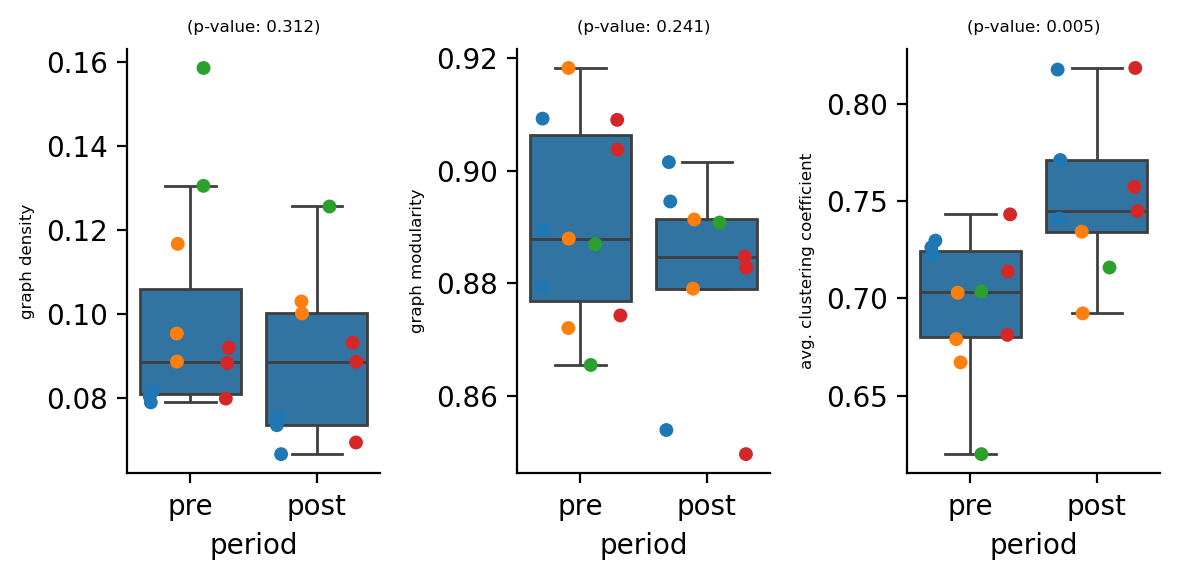

In [23]:
from scipy.stats import ttest_ind
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = [6,3], dpi = 200, constrained_layout = True)

pre_post_df['year-season'] = pre_post_df['year'].astype(str) + '-' + pre_post_df['season'].astype(str)
data = pre_post_df[pre_post_df['year-season'] != '2020-winter']

# Calculate t-test and plot "average_degree"
y = 'density'
pre_avg_deg = data[data['period'] == 'pre'][y]
post_avg_deg = data[data['period'] == 'post'][y]
t_stat, p_value = ttest_ind(pre_avg_deg, post_avg_deg)

sns.boxplot(data = data, 
            x = 'period', 
            y = y, 
            showfliers = False, 
            ax = axes[0])
sns.stripplot(data = data, 
              x = 'period', 
              y = y, 
              hue = 'season', 
              dodge=True,  # Add dodge=True to avoid overlap
              ax = axes[0],
              legend=False)

axes[0].set_title(f'(p-value: {p_value:.3f})', fontsize = 6)
axes[0].set_ylabel('graph density', fontsize = 6)

# Calculate t-test and plot "average_clustering_coefficient"
y = 'modularity'
pre_mod = data[data['period'] == 'pre'][y]
post_mod = data[data['period'] == 'post'][y]
t_stat, p_value = ttest_ind(pre_mod, post_mod)

sns.boxplot(data = data, 
            x = 'period', 
            y = y, 
            showfliers = False, 
            ax = axes[1])
sns.stripplot(data = data, 
              x = 'period', 
              y = y, 
              hue = 'season', 
              dodge=True,  # Add dodge=True to avoid overlap
              ax = axes[1],
              legend=False)

axes[1].set_title(f'(p-value: {p_value:.3f})', fontsize = 6)
axes[1].set_ylabel('graph modularity', fontsize = 6)

# Calculate t-test and plot "average_shortest_path_length"
y = 'average_clustering_coefficient'
data[y].replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(subset=[y], inplace=True)
pre_avg_clustering = data[data['period'] == 'pre'][y]
post_avg_clustering = data[data['period'] == 'post'][y]
t_stat, p_value = ttest_ind(pre_avg_clustering, post_avg_clustering)

sns.boxplot(data = data, 
            x = 'period', 
            y = y, 
            showfliers = False, 
            ax = axes[2])
sns.stripplot(data = data, 
              x = 'period', 
              y = y, 
              hue = 'season', 
              dodge=True,  # Add dodge=True to avoid overlap
              ax = axes[2],
              legend=False)

axes[2].set_title(f'(p-value: {p_value:.3f})', fontsize = 6)
axes[2].set_ylabel('avg. clustering coefficient', fontsize = 6)

# Adjust layout
plt.tight_layout()


sns.despine()

# Make the Figure
- Because of the many panels, this figure was produced here in parts, then assembled in Adobe Illustrator

In [24]:
import string
import itertools

years = list(range(2013, 2024))
seasons = ['spring', 'winter', 'autumn', 'summer']

# Define the panel labels
labels = list(string.ascii_uppercase) + list(string.ascii_lowercase)

# Initialize an empty dictionary
panel_A_mapping = {}

# Fill the dictionary
label_index = 0
for year in years:
    panel_A_mapping[year] = {}
    for season in seasons:
        panel_A_mapping[year][season] = labels[label_index]
        label_index += 1
        
# Define disallowed characters which include spaces, periods, specific quotes, and control characters
disallowed_chars = set(labels) | {' ', '.', '"', "'", '\t', '\n', '\r', '\x0b', '\x0c', '\\', ';'}

# Use printable characters and additional Unicode symbols, avoiding disallowed ones
additional_symbols = "±×÷√∞µθå∑£€©º∆ƒ"
symbols_for_b = [chr(i) for i in range(33, 127) if chr(i) not in disallowed_chars] + list(additional_symbols)

# Verify we have enough symbols
desired_label_count = len(years) * len(seasons)
if len(symbols_for_b) < desired_label_count:
    raise ValueError("Not enough unique symbols available to label each panel uniquely.")

# Fill the panel_B_mapping dictionary
panel_B_mapping = {}
label_index = 0
for year in years:
    panel_B_mapping[year] = {}
    for season in seasons:
        panel_B_mapping[year][season] = symbols_for_b[label_index]
        label_index += 1

/Users/jourjine/miniconda3/envs/test_audiomoth_env_20250225/lib/python3.9/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/jourjine/miniconda3/envs/test_audiomoth_env_20250225/lib/python3.9/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


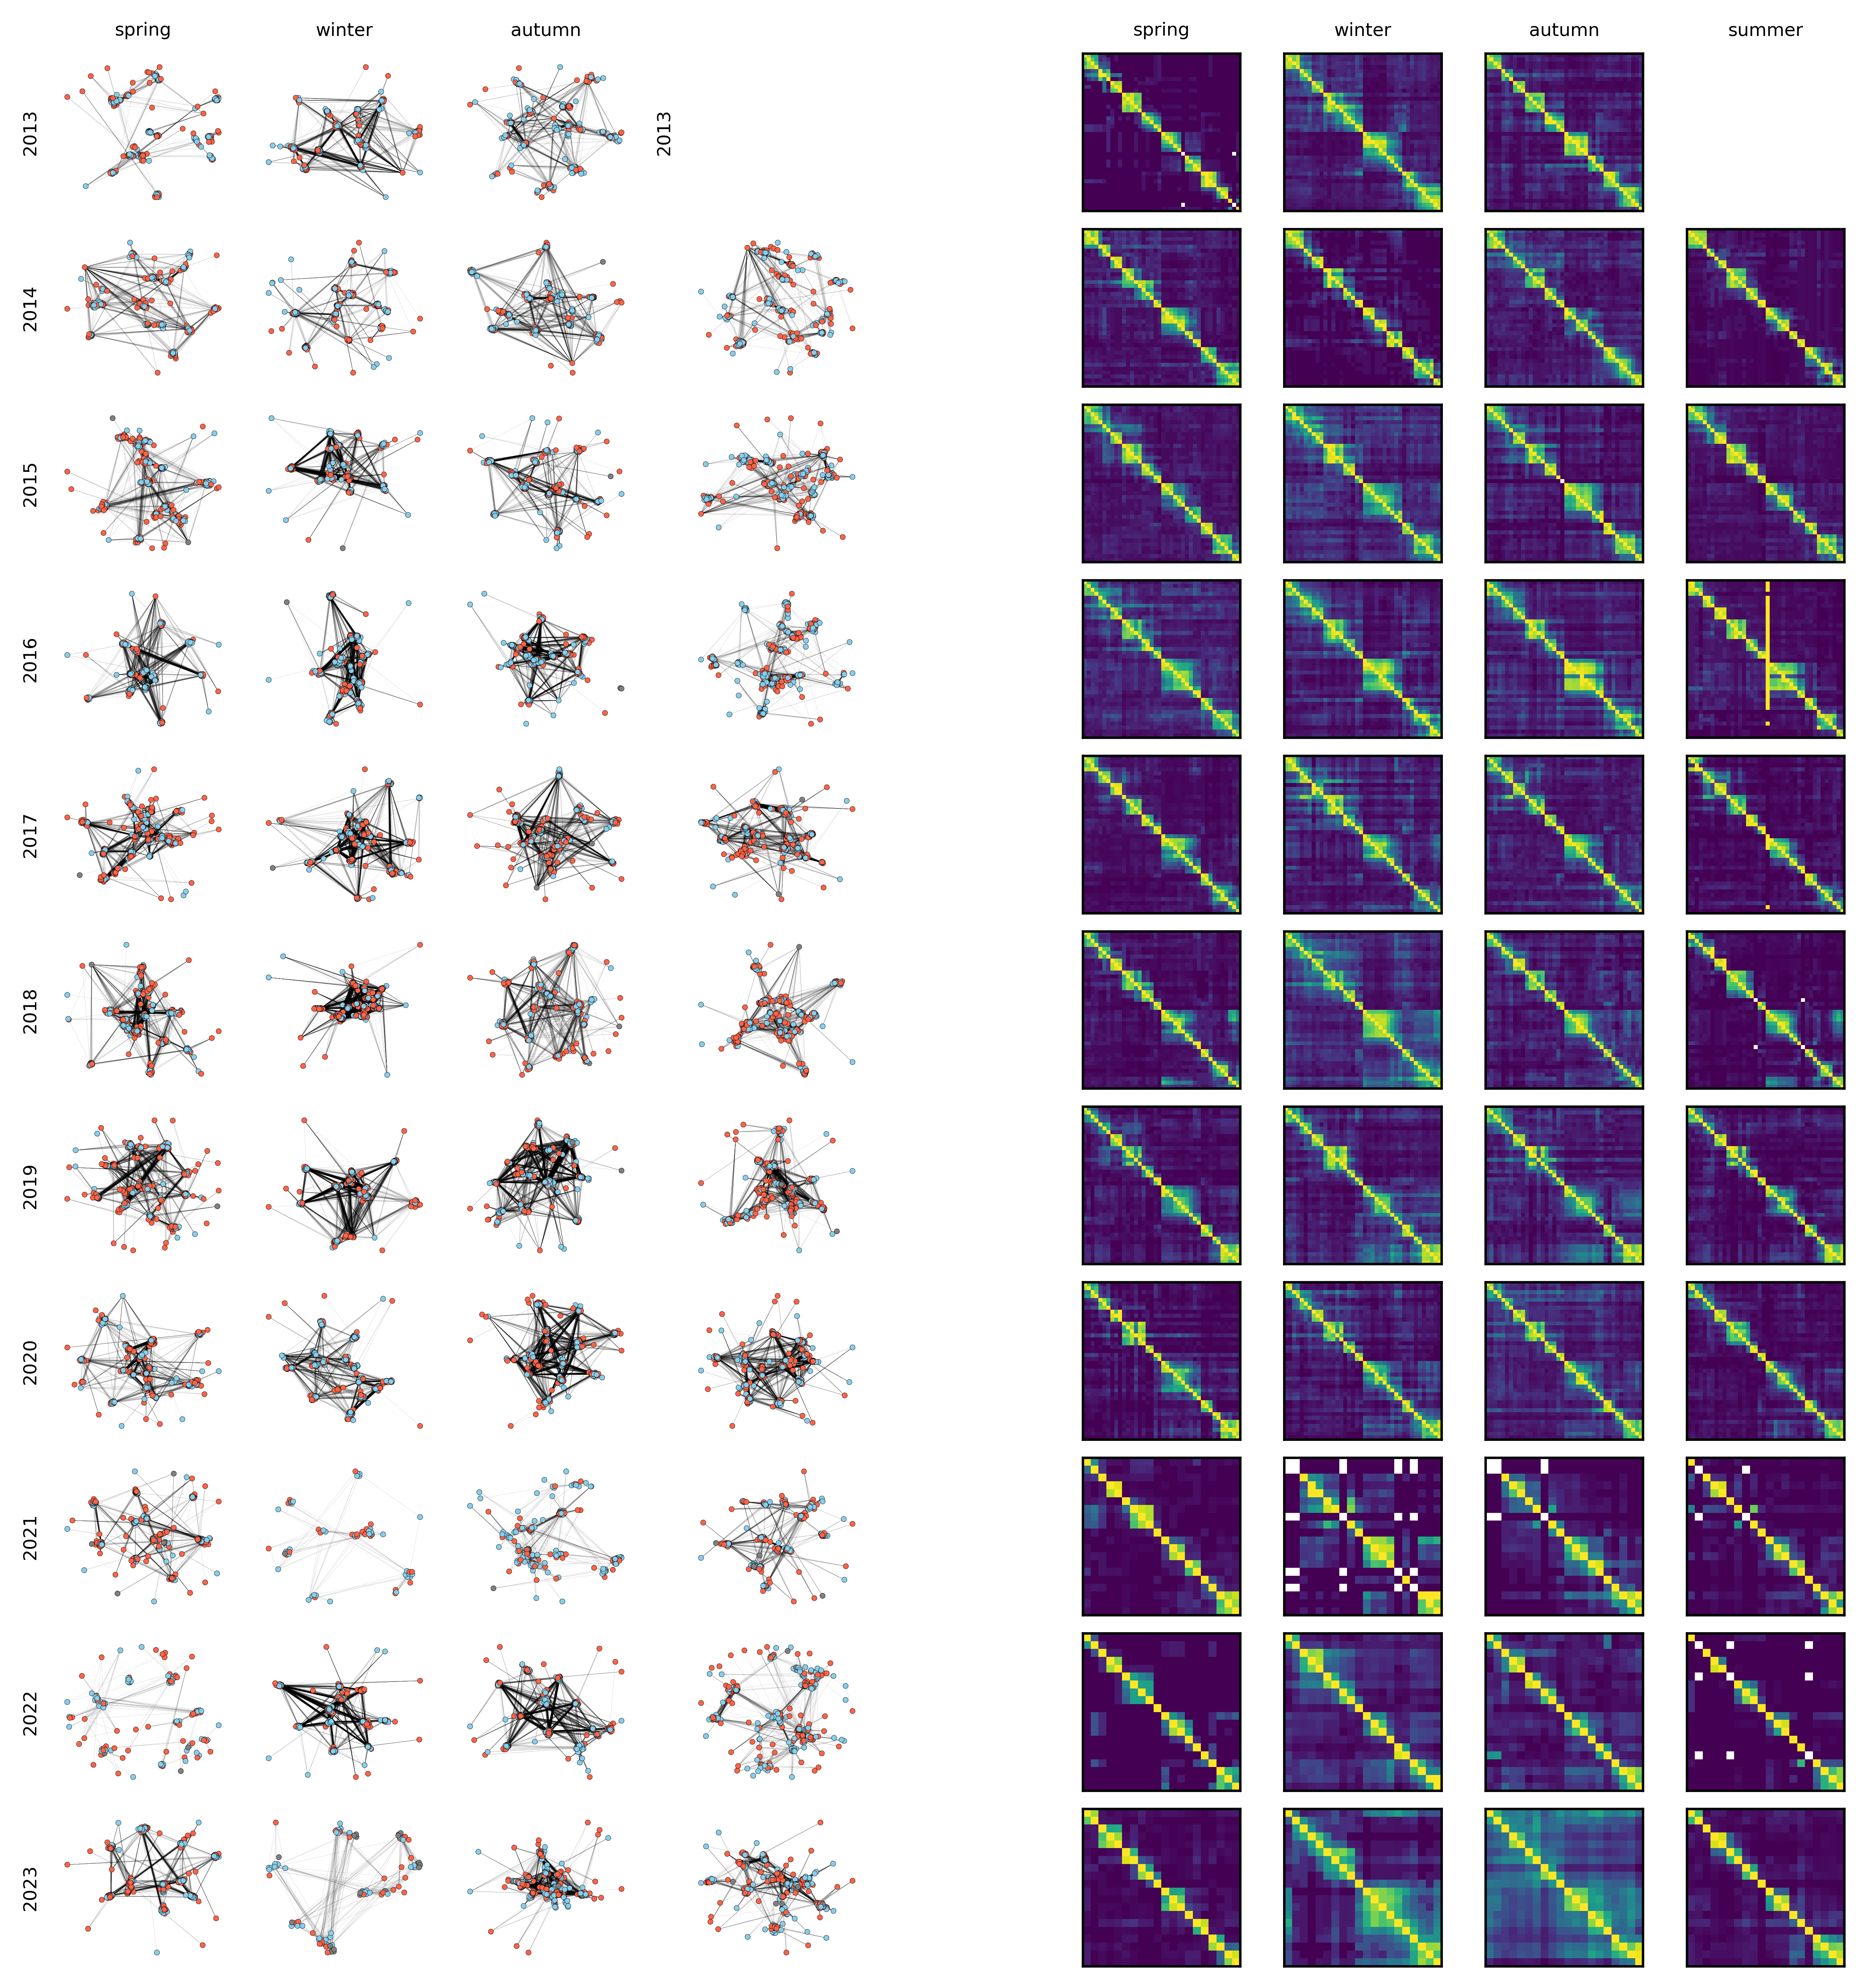

In [25]:
# save or not
save = False
path_to_save = ''


fig, axes = plt.subplot_mosaic(mosaic="ABCD.!#$%;"\
                                      "EFGH.&()*;"\
                                      "IJKL.+,-/;"\
                                      "MNOP.0123;"\
                                      "QRST.4567;"\
                                      "UVWX.89:<;"\
                                      "YZab.=>?@;"\
                                      "cdef.[]^_;"\
                                      "ghij.`{|};"\
                                      "klmn.~±×÷;"\
                                      "opqr.√∞µθ",
                               figsize=[8.5,9], 
                               constrained_layout=True,
                               gridspec_kw={"height_ratios": [0.3,0.3,0.3,0.3, 0.3,0.3,0.3,0.3, 0.3,0.3,0.3]},
                               dpi=600)

#plot parameters
tick_label_fontsize = 6
axis_label_fontsize = 9
title_label_fontsize = 12
num_ticks = 10 # for panel F x-axis
dot_size = 10
dot_alpha = .5
spine_width = 0.5

axes[panel_B_mapping[2013]['summer']].axis('off') # no data for this season

##################################################################################################
# panel A - plot all of the social networks
##################################################################################################

years = np.arange(2013,2024,1)
sex_colors_dict = {'M':'tomato', 'F':'skyblue'}
for year, year_axis in zip(years, range(len(years))):

    for season, season_axis in zip(seasons, range(len(seasons))):

        #get the network
        G = networks_dict[year][season]

        #get the subpanel to plot
        ax = panel_A_mapping[year][season]

        if G is not None:

            #color by sex
            sex_colors = [sex_colors_dict.get(sex_dict.get(int(name), float('NaN')), 'grey') for name in nx.get_node_attributes(G, 'name').values()]

            # Plot the graph with node colors based on clusters
            pos = nx.spring_layout(G, seed=12345, iterations=100) 

            nx.draw_networkx_nodes(G, 
                                   pos, 
                                   node_color=sex_colors, 
                                   node_size=3, 
                                   edgecolors='black', 
                                   linewidths=0.1, 
                                   ax=axes[ax])

            nx.draw_networkx_edges(G, 
                                   pos, 
                                   width=0.015, 
                                   ax=axes[ax])  # Draw edges

            if year == 2013:
                axes[ax].set_title(season, fontsize=tick_label_fontsize, rotation = 0)
            if season == 'spring':
                axes[ax].set_ylabel(year, fontsize=tick_label_fontsize, rotation = 90)
            axes[ax].spines['top'].set_visible(False)
            axes[ax].spines['right'].set_visible(False)
            axes[ax].spines['bottom'].set_visible(False)
            axes[ax].spines['left'].set_visible(False)
            axes[ax].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
            axes[ax].set_frame_on(False)

        else:
            if season == 'spring':
                axes[ax].set_title(season, fontsize=tick_label_fontsize, rotation = 0)
            if year == 2013:
                axes[ax].set_ylabel(year, fontsize=tick_label_fontsize, rotation = 90)
                

        axes[ax].spines['top'].set_visible(False)
        axes[ax].spines['right'].set_visible(False)
        axes[ax].spines['bottom'].set_visible(False)
        axes[ax].spines['left'].set_visible(False)
        axes[ax].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        sns.despine(ax = axes[ax], top=True, bottom=True, left=True, right=True)
        axes[ax].set_frame_on(False)
        
##################################################################################################
# panel A - plot all of the heatmaps
##################################################################################################

years = np.arange(2013,2024,1)
for year, year_axis in zip(years, range(len(years))):

    for season, season_axis in zip(seasons, range(len(seasons))):

        #get the network
        G = heatmaps_dict[year][season]

        #get the subpanel to plot
        ax = panel_B_mapping[year][season]
        
        #plot
        sns.heatmap(heatmaps_dict[year][season], 
                        annot=False, 
                        square = True,
                        fmt=".2f", 
                        cmap="viridis", 
                        ax=axes[ax], 
                        cbar=False)

        axes[ax].set_xticks([])
        axes[ax].set_xticklabels([])
        axes[ax].set_yticks([])
        axes[ax].set_yticklabels([])
            
        if year == 2013:
            axes[ax].set_title(season, fontsize=tick_label_fontsize, rotation = 0)
    
sns.despine(top = False, bottom = False, left = False, right = False)

if save:
    plt.savefig(os.path.join(path_to_save, 'Supplemental_Figure_2_top.jpeg'), dpi = 600)
    plt.savefig(os.path.join(path_to_save, 'Supplemental_Figure_2_top.svg'), dpi = 600)

/var/folders/h6/6fyt3jld5pq_w03ql1jw0gnh0000gn/T/ipykernel_7556/2976212408.py:146: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = small_world_df,


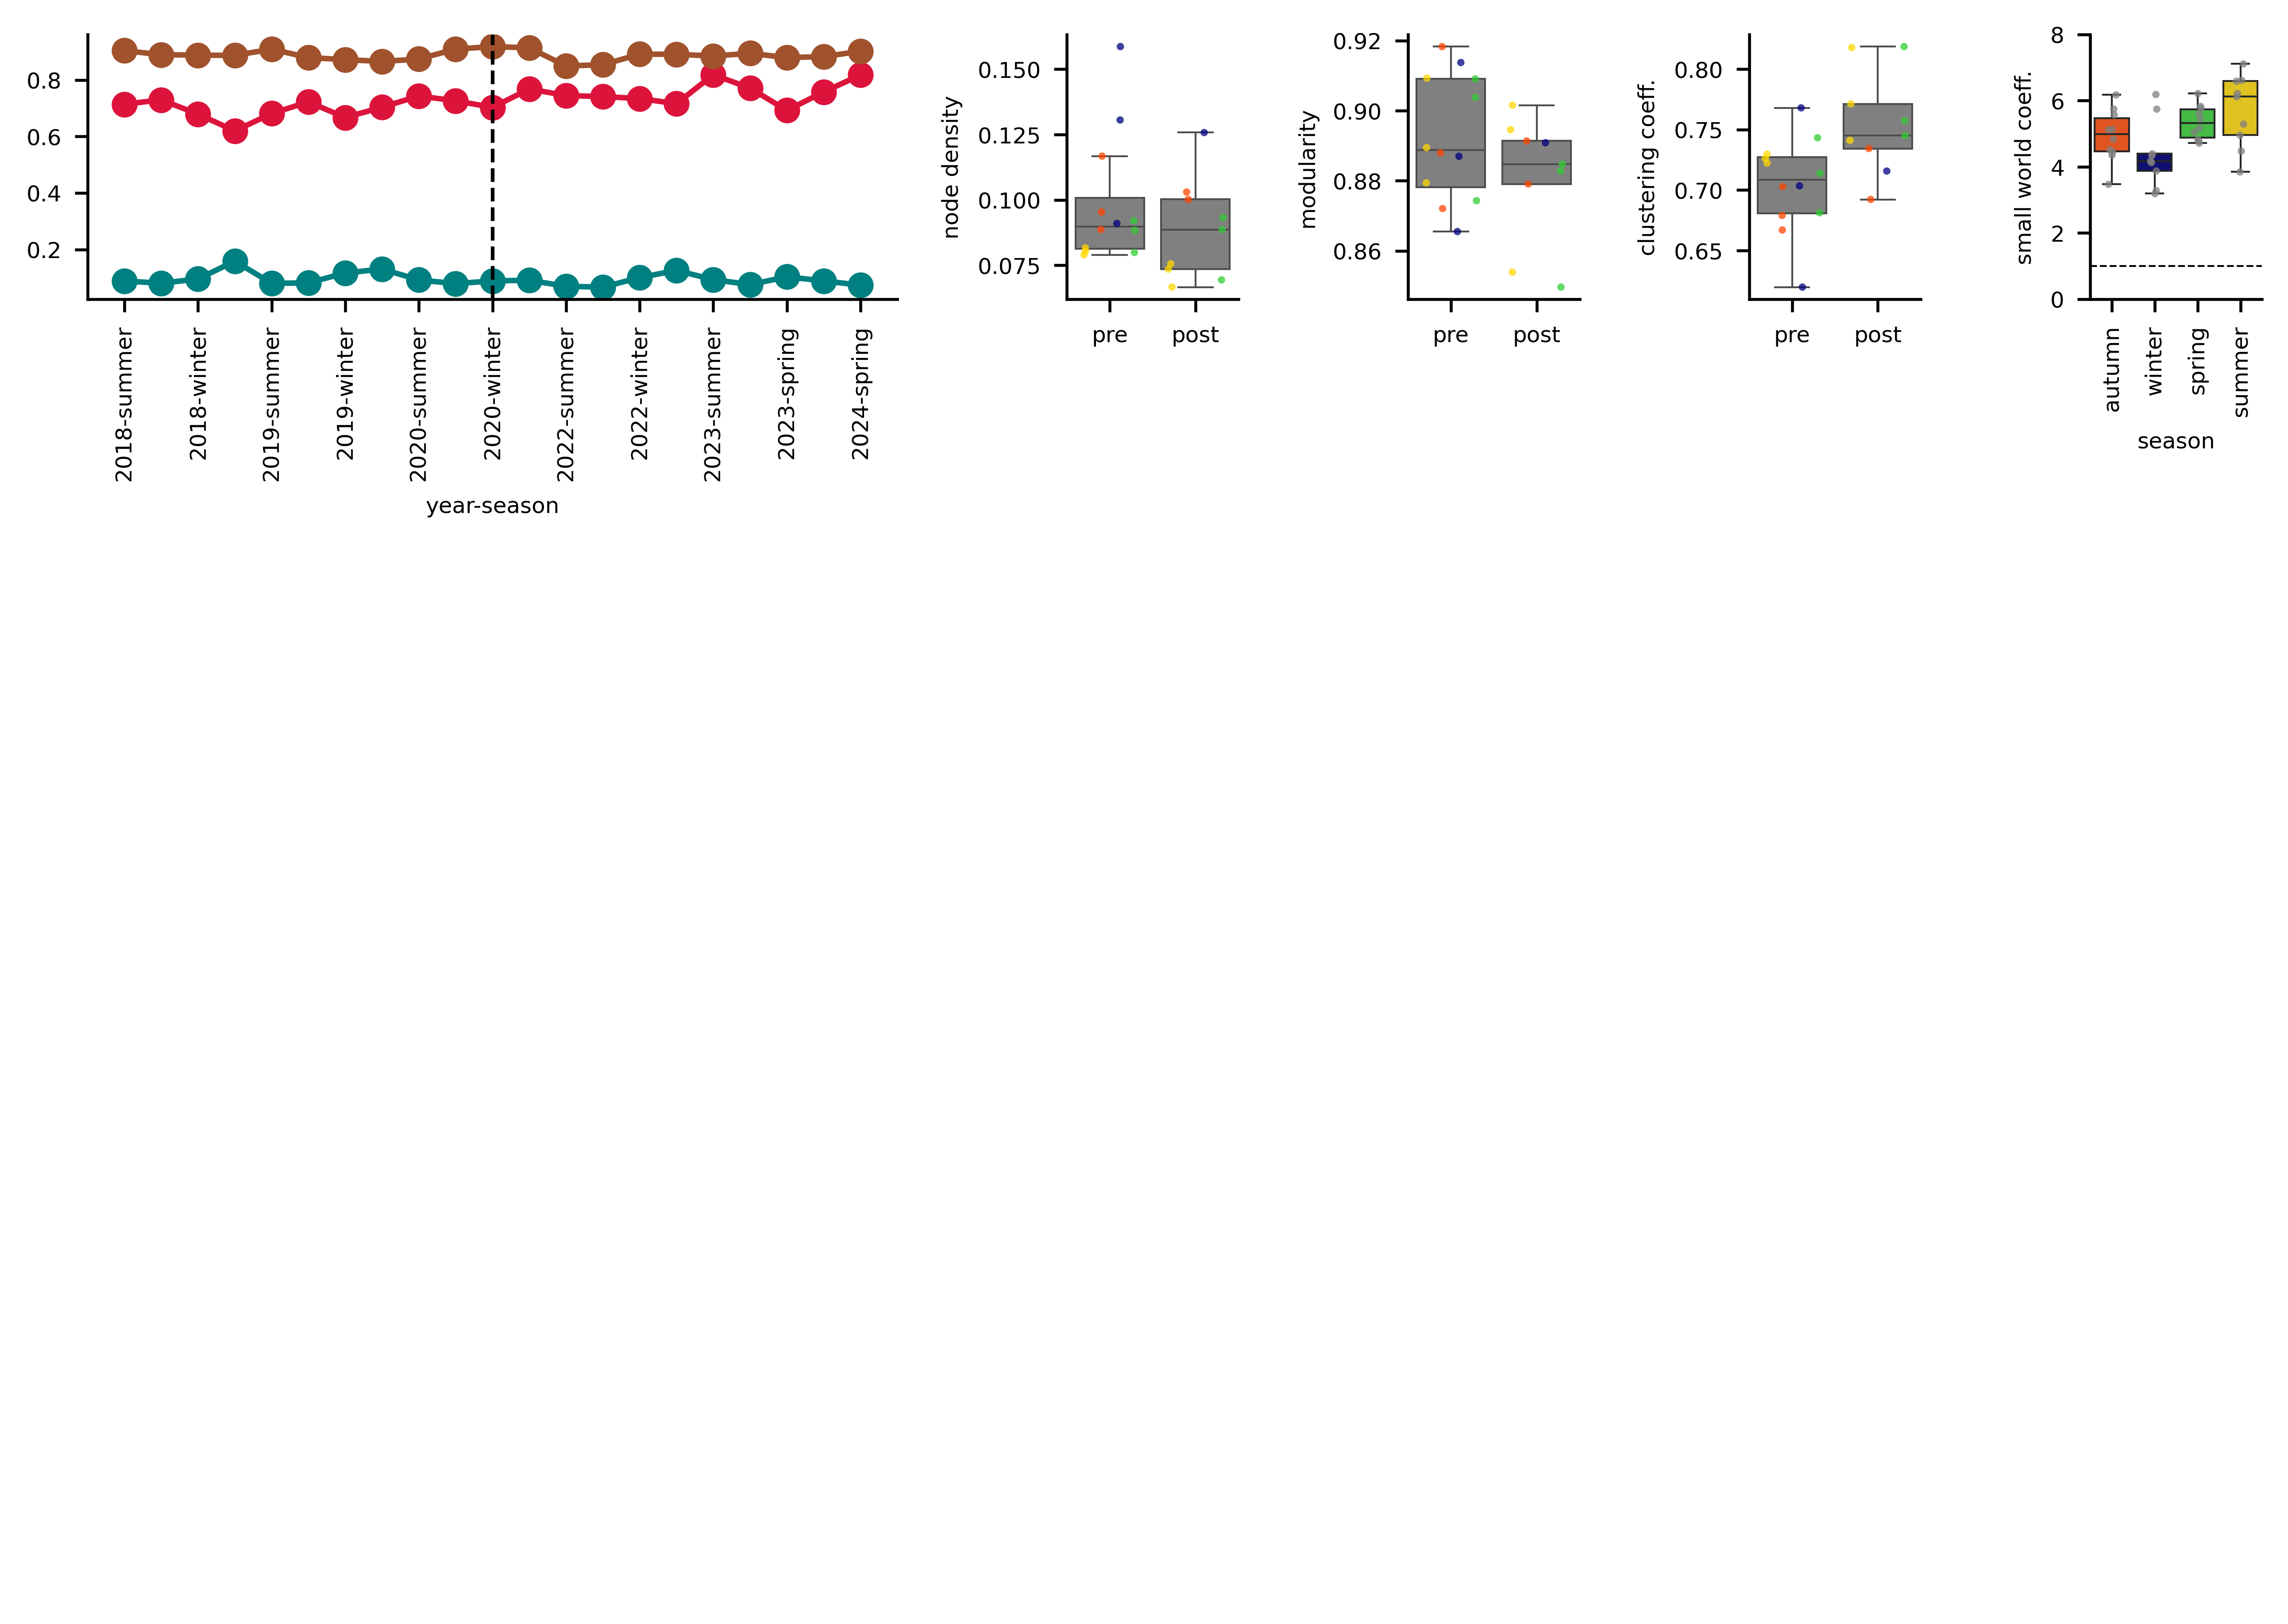

In [26]:
# save or not
save = False
path_to_save = ''

fig, axes = plt.subplot_mosaic(mosaic="ssstuvw;"\
                                      "^^^^^^^;"\
                                      "^^^^^^^",

                               figsize=[8.5,6], 
                               constrained_layout=True,
                               gridspec_kw={"height_ratios": [0.5, 1, 1]},
                               dpi=600)

#plot parameters
tick_label_fontsize = 6
axis_label_fontsize = 9
title_label_fontsize = 12
num_ticks = 10 # for panel F x-axis
dot_size = 10
dot_alpha = .5
spine_width = 0.5


axes["^"].axis('off')

season_colors_path = os.path.join(root,'parameters', 'json_files','season_color_dict.json')
season_colors = parameters.load_json(season_colors_path)


##################################################################################################
# panels s - plot the graph density, degree, and avg clustering coefficient time series
##################################################################################################    
 
#sort so the x axis is in order
season_order = ['spring', 'summer', 'autumn', 'winter']
pre_post_df['season'] = pd.Categorical(pre_post_df['season'], categories=season_order, ordered=True)
pre_post_df.sort_values(by=['year', 'season'], inplace=True)

#density
axes["s"].plot(pre_post_df['year'].astype(str) + '-' + pre_post_df['season'].astype(str), pre_post_df['density'], marker='o', c = 'teal')

#average clustering coefficient
axes["s"].plot(pre_post_df['year'].astype(str) + '-' + pre_post_df['season'].astype(str), pre_post_df['average_clustering_coefficient'], marker='o', c = 'crimson')

#modularity
axes["s"].plot(pre_post_df['year'].astype(str) + '-' + pre_post_df['season'].astype(str), pre_post_df['modularity'], marker='o', c = 'sienna')

# Set major ticks and labels to show every other tick
axes["s"].set_xlabel('year-season', fontsize=tick_label_fontsize)
axes["s"].tick_params(axis='x', rotation=90, labelsize=tick_label_fontsize - 3)
axes["s"].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)
x_labels = pre_post_df['year'].astype(str) + '-' + pre_post_df['season'].astype(str)
ticks = list(range(0, len(x_labels), 2))
axes["s"].set_xticks(ticks)
axes["s"].set_xticklabels([x_labels[i] for i in ticks])

# Identify positions of the target labels
removal_index = x_labels[x_labels == '2020-winter'].index[0]
axes["s"].axvline(x=removal_index, color='black', linestyle='--', linewidth=1, label='boxes removed')
    
##################################################################################################
# panels t - plot graph densities pre/post box removal
##################################################################################################  


sns.boxplot(data = pre_post_df, 
            x = 'period', 
            y = 'density', 
            showfliers = False, linewidth = 0.5,color = 'grey',
            ax = axes["t"])
sns.stripplot(data = pre_post_df, 
              x = 'period', 
              y = 'density', 
              hue = 'season', 
              palette = season_colors,
              hue_order = ['summer', 'autumn', 'winter', 'spring'],
              s = 2, 
              alpha = 0.75, 
              dodge=True,  # Add dodge=True to avoid overlap
              ax = axes["t"],
              legend=False)

axes["t"].set_xlabel('')
axes["t"].set_ylabel('node density', fontsize = tick_label_fontsize)
axes["t"].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)

##################################################################################################
# panels v - plot graph modularities pre/post box removal
##################################################################################################  


sns.boxplot(data = pre_post_df, 
            x = 'period', 
            y = 'modularity', color = 'grey',
            showfliers = False, linewidth = 0.5,
            ax = axes["u"])
sns.stripplot(data = pre_post_df, 
              x = 'period', 
              y = 'modularity', 
              hue = 'season', 
              palette = season_colors,
              hue_order = ['summer', 'autumn', 'winter', 'spring'],
              s = 2, 
              alpha = 0.75,
              dodge=True,  # Add dodge=True to avoid overlap
              ax = axes["u"],
              legend=False)

axes["u"].set_xlabel('')
axes["u"].set_ylabel('modularity', fontsize = tick_label_fontsize)
axes["u"].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)


##################################################################################################
# panels v - plot the avg clustering coefficient pre/post box removal
##################################################################################################  


sns.boxplot(data = pre_post_df, 
            x = 'period', 
            y = 'average_clustering_coefficient', 
            linewidth = 0.5,color = 'grey',
            showfliers = False, 
            ax = axes["v"])
sns.stripplot(data = pre_post_df, 
              x = 'period', 
              y = 'average_clustering_coefficient', 
              hue = 'season', 
              palette = season_colors,
              hue_order = ['summer', 'autumn', 'winter', 'spring'],
              s = 2,  
              alpha = 0.75,
              dodge=True,  # Add dodge=True to avoid overlap
              ax = axes["v"],
              legend=False)

axes["v"].set_xlabel('')
axes["v"].set_ylabel('clustering coeff.', fontsize = tick_label_fontsize)
axes["v"].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)

##################################################################################################
# panels v - plot the small world coefficients
##################################################################################################  


sns.boxplot(data = small_world_df, 
            x = 'season', 
            y = 'sigma', 
            showfliers = False, 
            palette = [season_colors[season] for season in small_world_df['season'].unique()], 
            linewidth = 0.5,
            ax = axes["w"])
sns.stripplot(data = small_world_df, 
              x = 'season', 
              y = 'sigma', 
              s = 2, 
              color = 'grey', 
              alpha = 0.75,
              dodge=True,  # Add dodge=True to avoid overlap
              ax = axes["w"],
              legend=False)

axes["w"].set_ylabel('small world coeff.', fontsize = tick_label_fontsize)
axes["w"].set_xlabel('season', fontsize = tick_label_fontsize)
axes["w"].set_ylim([0,8])
axes["w"].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)
axes["w"].axhline(y=1, linewidth = 0.5, linestyle = '--', color = 'black')
axes["w"].tick_params(axis='x', rotation=90)

sns.despine()

if save:
    plt.savefig(os.path.join(path_to_save, 'Supplemental_Figure_2_bottom.jpeg'), dpi = 600)
    plt.savefig(os.path.join(path_to_save, 'Supplemental_Figure_2_bottom.svg'), dpi = 600)

# Statistics

In [31]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pandas as pd
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scipy.stats as stats
import statsmodels.stats.multitest as smm
import statsmodels.stats.multicomp as multi
from src import modelselection

## Panel D

node density pre/post box removal

In [11]:
# Don't include the season during which the boxes were removed, just pre/post 2021
pre_post_df['year-season'] = pre_post_df['year'].astype(str) + '-' + pre_post_df['season'].astype(str)
data = pre_post_df[pre_post_df['year-season'] != '2020-winter']

# Calculate t-test and plot "average_degree"
y = 'density'
pre = data[data['period'] == 'pre'][y]
post = data[data['period'] == 'post'][y]
t_stat, p_value = ttest_ind(pre, post)
print('t_statistic:', t_stat)
print('p_value:', p_value)


## Panel E
modularity pre/post box removal

In [12]:
# Don't include the season during which the boxes were removed, just pre/post 2021
pre_post_df['year-season'] = pre_post_df['year'].astype(str) + '-' + pre_post_df['season'].astype(str)
data = pre_post_df[pre_post_df['year-season'] != '2020-winter']

# Calculate t-test and plot "average_clustering_coefficient"
y = 'modularity'
pre = data[data['period'] == 'pre'][y]
post = data[data['period'] == 'post'][y]
t_stat, p_value = ttest_ind(pre, post)
print('t_statistic:', t_stat)
print('p_value:', p_value)

## Panel F
average clustering coefficient pre/post box removal

In [13]:
# Don't include the season during which the boxes were removed, just pre/post 2021
pre_post_df['year-season'] = pre_post_df['year'].astype(str) + '-' + pre_post_df['season'].astype(str)
data = pre_post_df[pre_post_df['year-season'] != '2020-winter']

# Calculate t-test and plot "average_degree"
y = 'average_clustering_coefficient'
data[y].replace([np.inf, -np.inf], np.nan, inplace=True) # replace inf with nan
data.dropna(subset=[y], inplace=True)
pre = data[data['period'] == 'pre'][y]
post = data[data['period'] == 'post'][y]
t_stat, p_value = ttest_ind(pre, post)
print('t_statistic:', t_stat)
print('p_value:', p_value)


## Panel G
small world statistic

In [14]:
# Assuming your DataFrame 'small_world_df' is already loaded
data = small_world_df
dependent_var = 'sigma'
null_hypothesis_value = 1

# Ensure 'season' is treated as categorical and ordered if there's a preferred order
season_order = ['autumn', 'winter', 'spring', 'summer']
data['season'] = pd.Categorical(data['season'], categories=season_order, ordered=True)

# Ensure the dependent variable is numeric
data[dependent_var] = pd.to_numeric(data[dependent_var], errors='coerce')

# Drop rows where the dependent variable is NaN or inf
data=data[data['sigma'] < 1000000].dropna(subset = 'sigma')

# Initialize lists to store results
season_results = []
season_pvalues = []

# Perform one-sample t-tests for each season
for season in season_order:
    group = data[data['season'] == season][dependent_var]
    t_stat, p_value = stats.ttest_1samp(group, null_hypothesis_value, alternative='greater')
    
    # Store results
    season_results.append((season, t_stat, p_value))
    season_pvalues.append(p_value)

# Adjust p-values for multiple comparisons using Bonferroni correction
reject_bonf, pvals_corrected_bonf, _, _ = smm.multipletests(season_pvalues, alpha=0.05, method='bonferroni')

# Print the results with corrected p-values
for i, (season, t_stat, original_p) in enumerate(season_results):
    print(f"Season: {season}, t-statistic: {t_stat:.4f}, original p-value: {original_p:.4f}, Bonferroni p-value: {pvals_corrected_bonf[i]:.4f}, reject null: {reject_bonf[i]}")
    
# All
t_stat, p_value = stats.ttest_1samp(data[dependent_var], null_hypothesis_value, alternative='greater')
print(f"All: t-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")



In [15]:
## where to save
statistics_dir = ''
save = False # if true, save statistics csvs and output to statistics_dir

#fit the model, dropping nan and inf
dependent_var = 'sigma'
independent_var = 'season'
data=small_world_df[small_world_df['sigma'] < 1e30].dropna(subset = 'sigma') # drop inf and NaN
formula = f'{dependent_var} ~ C({independent_var})'
model = ols(formula, data = data).fit()

# Generate and print the ANOVA table
anova_table = sm.stats.anova_lm(model)
print(anova_table)

# Perform Tukey's HSD post-hoc test
mc = multi.MultiComparison(data[dependent_var], data[independent_var])
tukey_result = mc.tukeyhsd()
tukey_result = pd.DataFrame(data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0])

# Print the results of the Tukey HSD test
print(tukey_result)

analysis_name = 'supplementalfigure2_panelG'

if save:
    
    #save the analysis results
    modelselection.save_ANOVA_tables_to_word(analysis_name+': '+formula, anova_table, tukey_result, os.path.join(statistics_dir, analysis_name +'.docx'))
    
    #save the data the analysis was run on
    data.to_csv(os.path.join(statistics_dir, analysis_name + '.csv'), index = False)